In [1]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
print(os.listdir("journey\data"))

['.ipynb_checkpoints', 'df.pickle', 'funs.cpython-36_2.pyc', 'items.csv', 'item_categories.csv', 'new_cats.csv', 'new_sales1.csv', 'new_shops.csv', 'new_train.pickle', 'new_train2.pickle', 'sales_train.csv', 'sample_submission.csv', 'shops.csv', 'sub_data.pickle', 'sub_data2.pickle', 'test.csv', 'Untitled.ipynb']


# load the data

In [2]:
import os
import tarfile
from six.moves import urllib
PATH = os.path.join("journey", "data")
def load_data(file):
    csv_path = os.path.join(PATH,file)
    return pd.read_csv(csv_path)

#  Data leakage

In [ ]:
shops.shop_id.isin(l)

leakage=pd.merge(test,shops, how='inner', on="shop_id")
leakage["shop_id"].value_counts()

* shops not in the test data are:

In [ ]:
for i in range(60):
    if i not in leakage["shop_id"].values:
        print(i)

In [3]:
sales = pd.read_csv('journey/data/sales_train.csv' , index_col='date', parse_dates=['date'])
sales=sales.reset_index()

In [4]:
# Якутск Орджоникидзе, 56
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales.loc[sales.shop_id == 11, 'shop_id'] = 10


In [6]:
#l=[8, 13, 17, 23, 27, 29, 30, 32, 33, 40, 43, 51]

#drop shop_id that do not exist in test set
#sales_1=sales[~sales["shop_id"].isin(l)]

to_drop=sales[sales['item_cnt_day']>200]
drop=to_drop.item_id.value_counts()[to_drop.item_id.value_counts()<11].index
cnt_day_to_drop=to_drop[to_drop.item_id.isin(drop)].item_cnt_day
sales=sales[~sales.item_cnt_day.isin(cnt_day_to_drop)]#DROP THOSE ITEMS

grouped_df = sales.groupby('item_id').agg({'item_price':['min','max','mean','std']})
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
grouped_df = grouped_df.reset_index()
grouped_df=grouped_df[grouped_df["item_price_std"]>2500]
outlier_df=sales[sales['item_id'].isin(grouped_df['item_id'])]
to_drop=outlier_df.groupby("item_id")['item_price'].max()
sales=sales[~((sales['item_id'].isin(to_drop.index)) & (sales['item_price'].isin(to_drop)))]

In [7]:
grouped_df=sales.groupby("item_id").agg({'date':['min']})
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
sales = pd.merge(sales, grouped_df, on=['item_id'])

sales["month_min"]=pd.DatetimeIndex(sales.date_min).month
sales["year_min"]=pd.DatetimeIndex(sales.date_min).year

sales["month"]=pd.DatetimeIndex(sales.date).month
sales["year"]=pd.DatetimeIndex(sales.date).year

In [10]:
sales[(sales.month==sales.month_min)&(sales.year==sales.year_min)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_min,month_min,year_min,month,year
1,2013-01-23,0,24,22154,999.0,1.0,2013-01-04,1,2013,1,2013
2,2013-01-20,0,27,22154,999.0,1.0,2013-01-04,1,2013,1,2013
5,2013-01-20,0,25,22154,999.0,1.0,2013-01-04,1,2013,1,2013
6,2013-01-23,0,25,22154,999.0,1.0,2013-01-04,1,2013,1,2013
7,2013-01-26,0,25,22154,999.0,1.0,2013-01-04,1,2013,1,2013


In [16]:
sales=sales.drop("item_cnt_day_mean",axis=1)

In [17]:
grouped_df=sales[(sales.month==sales.month_min)&(sales.year==sales.year_min)].groupby(["shop_id"]).agg({"item_cnt_day":['mean']})
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
sales = pd.merge(sales, grouped_df, on=['shop_id'])

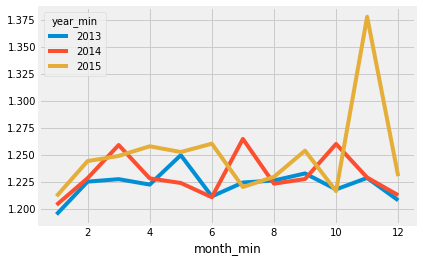

In [18]:
sales.groupby(["month_min","year_min"]).item_cnt_day_mean.mean().unstack().plot()

In [9]:
grouped_df=sales.groupby("item_id").agg({'date':['max']})
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
sales = pd.merge(sales, grouped_df, on=['item_id'])

sales["month_max"]=pd.DatetimeIndex(sales.date_max).month
sales["year_max"]=pd.DatetimeIndex(sales.date_max).year

In [49]:
grouped_df=sales.groupby("item_id").agg({'date_block_num':['min']})
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
sales = pd.merge(sales, grouped_df, on=['item_id'])

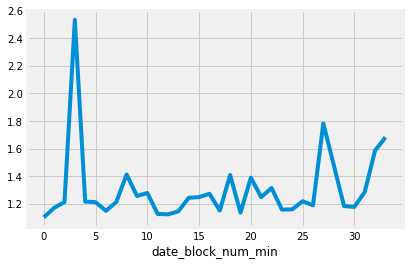

In [51]:
sales.groupby(["date_block_num_min"]).item_cnt_day.mean().plot()

In [ ]:
grouped_df=sales[(sales.date_block_num==sales.date_block_num_min)].groupby(["shop_id"]).agg({'item_cnt_day':{'new_shop':np.mean}})
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
all_data = pd.merge(all_data, grouped_df, on=["shop_id"],how="left")

grouped_df=sales[(sales.date_block_num==sales.date_block_num_min)].groupby(["item_category_id"]).agg({'item_cnt_day':{'new_cats':np.mean}})
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
all_data = pd.merge(all_data, grouped_df, on=['item_category_id'],how="left")

In [50]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_min,month_min,year_min,month,year,item_cnt_day_mean,date_block_num_min
0,2013-02-01,0,59,22154,999.0,1.0,2013-01-04,1,2013,2,2013,1.114738,0
1,2013-01-23,0,24,22154,999.0,1.0,2013-01-04,1,2013,1,2013,1.171342,0
2,2015-10-10,33,24,22154,299.0,1.0,2013-01-04,1,2013,10,2015,1.171342,0
3,2013-01-20,0,27,22154,999.0,1.0,2013-01-04,1,2013,1,2013,1.208432,0
4,2015-12-07,30,27,22154,299.0,1.0,2013-01-04,1,2013,12,2015,1.208432,0


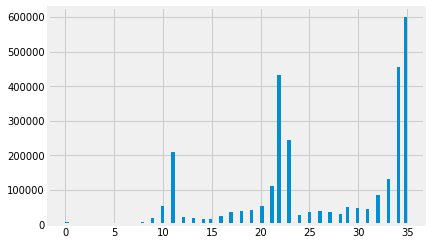

In [18]:
sales.item_date_time.hist(bins=100)


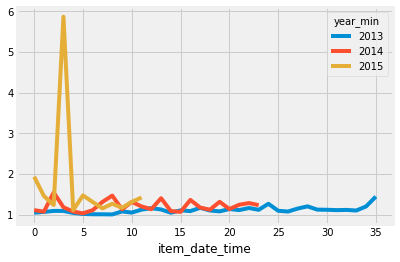

In [76]:
sales.groupby(["item_date_time","year_min"]).item_cnt_day.mean().unstack().plot()

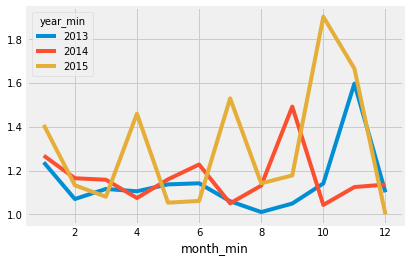

In [57]:
sales.groupby(["month_min","year_min"]).item_cnt_day.mean().unstack().plot()

In [31]:
for i in range(1,13):
    print(sales[(sales.month==i)& (sales.year_min==2015)].shape)

(6663, 15)
(10702, 15)
(14600, 15)
(16046, 15)
(17040, 15)
(17082, 15)
(17227, 15)
(19867, 15)
(17870, 15)
(21541, 15)
(6126, 15)
(5267, 15)


In [29]:
for i in range(1,13):
    print(sales[(sales.month_min==i) & (sales.year_min==2015)].shape)

(152908, 15)
(7001, 15)
(2663, 15)
(995, 15)
(447, 15)
(390, 15)
(1001, 15)
(528, 15)
(499, 15)
(3575, 15)
(9, 15)
(15, 15)


In [54]:
noise_11=sales[(sales.month_min==11) & (sales.year_min==2015)].item_id.unique()

noise_12=sales[(sales.month_min==12) & (sales.year_min==2015)].item_id.unique()

test = pd.read_csv('journey/data/test.csv')
np.isin(noise_11 , test.item_id.unique())
np.isin(noise_12 , test.item_id.unique())

In [21]:
sales.to_pickle('journey/data/new_sales1.csv')

In [58]:
sales=sales[~sales.item_id.isin(noise_11)]
sales=sales[~sales.item_id.isin(noise_12)]

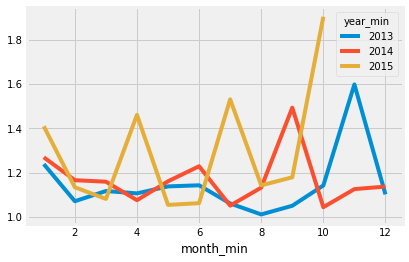

In [59]:
sales.groupby(["month_min","year_min"]).item_cnt_day.mean().unstack().plot()

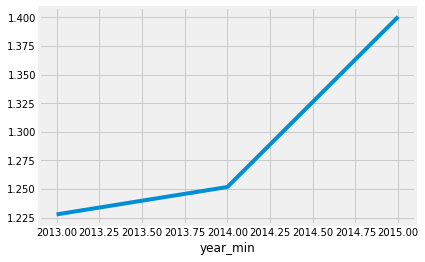

In [79]:
sales.groupby(["year_min"]).item_cnt_day.mean().plot()

In [62]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_min,month_min,year_min,month,year,date_max,month_max,year_max,item_date_time
0,2013-02-01,0,59,22154,999.0,1.0,2013-01-04,1,2013,2,2013,2015-12-07,12,2015,35.0
1,2013-01-23,0,24,22154,999.0,1.0,2013-01-04,1,2013,1,2013,2015-12-07,12,2015,35.0
2,2013-01-20,0,27,22154,999.0,1.0,2013-01-04,1,2013,1,2013,2015-12-07,12,2015,35.0
3,2013-02-01,0,25,22154,999.0,1.0,2013-01-04,1,2013,2,2013,2015-12-07,12,2015,35.0
4,2013-03-01,0,25,22154,999.0,1.0,2013-01-04,1,2013,3,2013,2015-12-07,12,2015,35.0


In [71]:
for i in range(0,4):
    sales.loc[(sales.year_min==2013)& (sales.month.isin([1+3*i,2+3*i,3+3*i])),"season"]=i+1

In [72]:
for i in range(0,4):
    sales.loc[sales.year_min==2014 & sales.month.isin([1+3*i,2+3*i,3+3*i]),"season"]=i+1

In [73]:
for i in range(0,4):
    sales.loc[sales.year_min==2015 & sales.month.isin([1+3*i,2+3*i,3+3*i]),"season"]=i+1

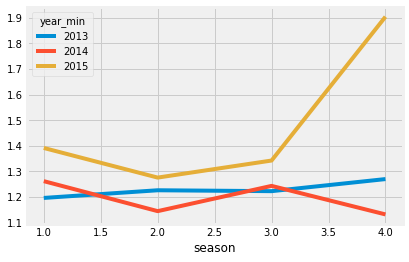

In [74]:
sales.groupby(["season","year_min"]).item_cnt_day.mean().unstack().plot()

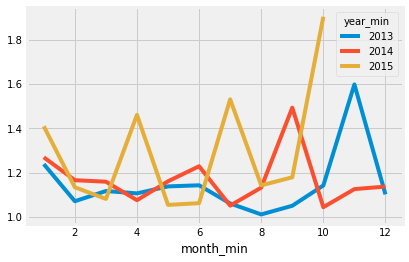

In [80]:
sales.groupby(["month_min","year_min"]).item_cnt_day.mean().unstack().plot()

In [81]:
sales.loc[sales['year_min'] == 2013, 'item_time'] = 36

sales.loc[sales['year_min'] == 2014, 'item_time'] = 24

sales.loc[sales['year_min'] == 2015, 'item_time'] = 12

l=sales.item_time-sales.month_min

sales["item_time"]=l

In [113]:
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'date_min', 'month_min', 'year_min', 'month', 'year',
       'date_max', 'month_max', 'year_max', 'item_date_time', 'new_cats_x',
       'item_category_id_x', 'new_cats_y', 'item_category_id_y', 'new_cats',
       'item_category_id', 'item_time'],
      dtype='object')

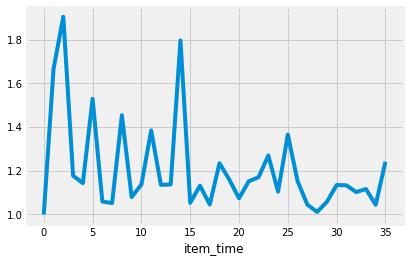

In [121]:
sales.groupby(["item_time"]).item_cnt_day.mean().plot()

In [134]:
sales[sales.item_time.isin([1,0])].shape

(24, 18)

In [135]:
sales[sales.item_time.isin([2])].shape

(3564, 18)

In [136]:
sales.loc[sales['item_time'].isin([1,0]), 'item_time']=0